# Preliminaries

In [1]:
# Required standard libraries
import pandas as pd
import json
import urllib
import requests
import os
import re
import numpy as np
import bs4 as bs
import selenium
import html5lib
#import nltk
import datetime
from selenium import webdriver

# Extractors 
import extract

# Cleansers (cluster specific)
import cleanse

# Normalizer (generalised across all clusters)
from normalize import scaler

# Utils
from utils import utils

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Define filepaths

In [2]:
# Define the export path for all data exports
from pathlib import Path

# Current working directory
cwd = Path('.')

# Folder with data-in artifacts, quired to run this script
data_in = cwd / 'data_in'

# Folder containing manually extracted raw data, ready to be put in the loop
data_sources_staged_raw = cwd / 'data_out' / 'data_staged_raw'
data_sources_staged_raw.mkdir(parents=True, exist_ok=True)

# Folder to export raw data
data_sources_raw = cwd / 'data_out' / 'data_raw'
data_sources_raw.mkdir(parents=True, exist_ok=True)

# Folder to export cleansed data
data_sources_cleansed = cwd / 'data_out' / 'data_cleansed'
data_sources_cleansed.mkdir(parents=True, exist_ok=True)

# Folder to export normalized data
data_sources_normalized = cwd / 'data_out' / 'data_normalized'
data_sources_normalized.mkdir(parents=True, exist_ok=True)

## Load country list and mapping dictionary

In [8]:
# Load the list of countries which contains all different variations of country names 
country_full_list = pd.read_excel(
    data_in / 'all_countrynames_list.xlsx',
    keep_default_na = False).drop_duplicates()

# Create a version of the list with unique ISO2 and ISO3 codes
country_iso_list = country_full_list.drop_duplicates(subset = 'COUNTRY_ISO_2')

# Country CRBA list, this is the list of the countries that should be in the final CRBA indicator list
country_crba_list = pd.read_excel(
    data_in / 'crba_country_list.xlsx',
    header = None,
    usecols = [0, 1], 
    names = ['COUNTRY_ISO_3', 'COUNTRY_NAME']).merge(
        right = country_iso_list[['COUNTRY_ISO_2', 'COUNTRY_ISO_3']],
        how = 'left',
        on='COUNTRY_ISO_3',
        validate = 'one_to_one')

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'column_mapping.py') as file:
    exec(file.read())

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'value_mapping.py') as file:
    exec(file.read())

## Read data dictionary

In [11]:
# sources sheet
crba_data_dictionary_source = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Source",
    keep_default_na = False
)

# snapshot sheet
crba_data_dictionary_snapshot = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Snapshot",
    keep_default_na = False
)

# indicator sheet
crba_data_dictionary_indicator = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Indicator",
    keep_default_na = False
)

# Input lists
crba_data_dictionary_input_list = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Input_Lists",
    keep_default_na = False
)

# Add 2-digit shortcodes of index, issue and category to indicators sheet
crba_data_dictionary_indicator = crba_data_dictionary_indicator.merge(
    right=crba_data_dictionary_input_list[['INDEX', 'INDEX_CODE']],
    left_on='INDEX',
    right_on='INDEX'
).merge(
    right=crba_data_dictionary_input_list[['ISSUE', 'ISSUE_CODE']],
    left_on='ISSUE',
    right_on='ISSUE'
).merge(
    right=crba_data_dictionary_input_list[['CATEGORY', 'CATEGORY_CODE']],
    left_on='CATEGORY',
    right_on='CATEGORY'
)

# Create indicator code prefix (INDEX-ISSUE_CAEGORY CODE)
crba_data_dictionary_indicator = crba_data_dictionary_indicator.assign(
    INDICATOR_CODE_PREFIX = crba_data_dictionary_indicator.INDEX_CODE +
    "_" +
    crba_data_dictionary_indicator.ISSUE_CODE+
    "_"+
    crba_data_dictionary_indicator.CATEGORY_CODE+
    "_")

# Create indicator code
crba_data_dictionary_indicator = crba_data_dictionary_indicator.assign(
    INDICATOR_CODE = crba_data_dictionary_indicator.INDICATOR_CODE_PREFIX + crba_data_dictionary_indicator.INDICATOR_NAME.apply(
    lambda x: utils.create_ind_code(x)
))

In [ ]:
import importlib, inspect

extractors = { 
    cls.type: cls for name, cls in inspect.getmembers(
        importlib.import_module("extract"), 
        inspect.isclass
    ) if hasattr(cls, 'type')
}

# Staging (pre-processing) to create exceptional indicators´ raw data 

#

In [5]:
# Pre-processing of exceptional indicators, which require extra transformation
# Important: File requires having filepaths from above defined and pandas already imported
with open(data_in / 'staging_create_raw_data.py') as file:
    exec(file.read())

The following columns are present in the datasets, and this is the number of unique values they have. 
The column goal has 3 unique values.
The column target has 3 unique values.
The column indicator has 3 unique values.
The column series has 1 unique values.
The column seriesDescription has 1 unique values.
The column seriesCount has 1 unique values.
The column geoAreaCode has 98 unique values.
The column geoAreaName has 98 unique values.
The column timePeriodStart has 15 unique values.
The column value has 599 unique values.
The column valueType has 1 unique values.
The column time_detail has 1 unique values.
The column timeCoverage has 1 unique values.
The column upperBound has 1 unique values.
The column lowerBound has 1 unique values.
The column basePeriod has 1 unique values.
The column source has 1 unique values.
The column geoInfoUrl has 1 unique values.
The column footnotes has 1 unique values.
The column attributes.Nature has 1 unique values.
The column attributes.Units has 1

# Extract - Transform - Load Loop
## API sources
### CSV API sources

In [7]:
# CSV sources
api_sources = crba_data_dictionary_source[
    #(crba_data_dictionary_source["SOURCE_TYPE"] == "API (ILO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNESCO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (WHO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNICEF)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (NRGI)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# # # # # # # # # # # #
# Delete again (only for temporary debugging 12.11.20)
# # # # # # # # # # # # 
api_sources = api_sources[(api_sources["SOURCE_ID"] == 'S-155') | 
(api_sources["SOURCE_ID"] == 'S-156')]
#api_sources = api_sources[(api_sources["SOURCE_ID"] == 'S-97')]

# define emty dataframe
combined_cleansed_csv = pd.DataFrame()
combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Extraction section
    # try:
        # Extract data
    # print(row["ENDPOINT_URL"]+"continue here")
    dataframe = extract.CSVExtractor.extract(url = row["ENDPOINT_URL"])
    
    # Save raw data
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )
    
    # except:
    print("There was a problem with extraction of source {} \n".format(row["SOURCE_ID"]))
    
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )

    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )
    
    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    cleanse.Cleanser().create_log_report(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-155 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column CountryISO has 81 unique values.
The column Country has 83 unique values.
The column Sector has 2 unique values.
The column Region has 7 unique values.
The column ElementNumber has 205 unique values.
The column ElementType has 8 unique values.
The column ElementName has 205 unique values.
The column Score has 102 unique values.
There was a problem with extraction of source S-155 


 - - - - - 
 Cleansing source S-155 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...
      COUNTRY_NAME DIM_SECTOR  TIME_PERIOD  \
0      Afghanistan     Mining         2017   
1      Afghanistan     Mining         2017   
2      Afghanistan     Mining     

### JSON API sources

In [7]:
# JSON sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (SDG)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (WB)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# # # # # # # # # # # #
# Delete again (only for temporary debugging 12.11.20)
# # # # # # # # # # # # 
"""
api_sources = api_sources[
    (api_sources["SOURCE_ID"] == 'S-222') | 
    (api_sources["SOURCE_ID"] == 'S-223') |
    (api_sources["SOURCE_ID"] == 'S-224') |
    (api_sources["SOURCE_ID"] == 'S-225') |
    (api_sources["SOURCE_ID"] == 'S-226')
]
"""
#combined_cleansed_csv = pd.DataFrame()
#combined_normalized_csv = pd.DataFrame()
##############################################

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    #try:
    # Extract data 
    dataframe = extract.JSONExtractor.extract(url = row["ENDPOINT_URL"])
    
    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")
    # except:
        #print("There was an issue with source {}".format(row["SOURCE_ID"]))
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing in 
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    # print(dataframe)

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )

    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )

    # print(dataframe)

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"],
        na_encodings = row["NA_ENCODING"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-23 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column goal has 1 unique values.
The column target has 1 unique values.
The column indicator has 1 unique values.
The column series has 1 unique values.
The column seriesDescription has 1 unique values.
The column seriesCount has 1 unique values.
The column geoAreaCode has 86 unique values.
The column geoAreaName has 86 unique values.
The column timePeriodStart has 20 unique values.
The column value has 3190 unique values.
The column valueType has 1 unique values.
The column time_detail has 1 unique values.
The column timeCoverage has 1 unique values.
The column upperBound has 1 unique values.
The column lowerBound has 1 unique values.
The column basePeriod has 1 unique values.
The column source has 51 unique values.
The column geoInfoUrl has 1 unique values.
The column footnotes has 17 unique values.
The column attributes.Nature has 2 unique

## HTML Sources
### UN Treaty Sources

In [35]:
# 
test_string = "New Zealand 45, 46, 47, 48, 49"
test_string_2 = "Netherlands 44"
test_string_3 = "Germany 24, 25, 26"

re.sub('\s\d+,\s\d+,', '', test_string)
re.sub('\s\d+.*', '', test_string_3)


'Germany'

In [36]:
# UN Treaty HTML sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "UN Treaties")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    dataframe = extract.HTMLExtractor().extract(url = row["ADDRESS"])
    
    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")

    # Cleansing
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    # UN Treaty data specific: Sometimes, countries have footnotes (numbers). These must be purged for the rest of the code to work properly
    dataframe['COUNTRY_NAME'] = dataframe['COUNTRY_NAME'].apply(lambda x: re.sub('\s\d+.*', '', x)) # deleted everything after number (and the leading whitespace)

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body = row["SOURCE_BODY"]
    )

    cleanse.Cleanser().create_log_report(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-4 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column Participant has 180 unique values.
The column Signature has 35 unique values.
The column Ratification, Acceptance(A), Approval(AA), Accession(a), Succession(d) has 172 unique values.

 - - - - - 
 Cleansing source S-4 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...
                           COUNTRY_NAME ATTR_RATIFICATION_DATE COUNTRY_ISO_2  \
0                           Afghanistan          15 Aug 2014 a            AF   
1                               Albania            21 Aug 2002            AL   
2                               Algeria             9 Mar 2004            DZ   
3                                Angola          19 Sep 2014 a            AO   
4                   Antigua and Barbuda            17 Feb 2010            AG   
..                                  ...        

## Other sources
### WPA sources

In [8]:
# 1. Create a flat file of all WPA sources
# Read and join all world policy analysis centre data
wpa_child_labor = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_8, S_9' / 'WORLD_child_labor.xls'
)

wpa_childhood = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_10, S_13, S_36, S_45, S_49' / 'WORLD_Dataset_Childhood_4.16.15.xls'
)

wpa_adult_labor = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_40, S_41, S_63, S_64, S_65, S_66, S_67, S_68' / 'WORLD_Dataset_Adult_Labor_9.17.2018.xls'
)

wpa_discrimination = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_42, S_43, S_44' / 'WORLD_discrimination_at_work.xls'
)

# Create list to write a loop
wpa_combined_list=[
    wpa_childhood,
    wpa_adult_labor,
    wpa_discrimination
 ]

# Loop to join all dataframes
wpa_combined = wpa_child_labor

for df in wpa_combined_list:
    wpa_combined = wpa_combined.merge(
        right=df,
        on=['iso2', 'iso3']
    )

# 2. Loop
wpa_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "World Policy Analysis Centre")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# # # # # # # # # # # # # # # # # # # # 
# combined_cleansed_csv = pd.DataFrame()
# combined_normalized_csv = pd.DataFrame()


# Loop to extract data from API sources
for index, row in wpa_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    #try:
    # Extract data 
    # Log that we are entering cleasning
    print("\n Extracting data and store it as raw data")

    dataframe = wpa_combined[['iso3', row['WPA_OBS_RAW_COL']]] 
    dataframe['TIME_PERIOD'] = row['WPA_YEAR_COL'] 

    print(dataframe.head(30))

    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")
    #except:
    print("There was an issue with source {}".format(row["SOURCE_ID"]))
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing 
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    print(dataframe['RAW_OBS_VALUE'].unique())

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    cleanse.Cleanser().create_log_report(
        cleansed_data=dataframe_cleansed
    )

    
    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )
    

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")

    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )

    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-8 


 Extracting data and store it as raw data
   iso3  admiss_age  TIME_PERIOD
0   AFG         5.0         2019
1   ALB         5.0         2019
2   DZA         5.0         2019
3   AND         5.0         2019
4   AGO         5.0         2019
5   ATG         3.0         2019
6   ARG         5.0         2019
7   ARM         5.0         2019
8   AUS         4.0         2019
9   AUT         4.0         2019
10  AZE         4.0         2019
11  BHS         5.0         2019
12  BHR         4.0         2019
13  BGD         3.0         2019
14  BRB         5.0         2019
15  BLR         5.0         2019
16  BEL         4.0         2019
17  BLZ         3.0         2019
18  BEN         3.0         2019
19  BTN         2.0         2019
20  BOL         3.0         2019
21  BIH         4.0         2019
22  BWA         4.0         2019
23  BRA         5.0         2019
24  BRN         5.0         2019
25  BGR         5.0         2019
26  BFA         5.0         

## Export concatented dataframe

In [10]:
# # # # # CLEANSED DATA

# Idenify all dimension columns in combined dataframe
available_dim_cols = []
for col in combined_cleansed_csv.columns:
    dim_col = re.findall("DIM_.+", col)
    # print(dim_col)
    if len(dim_col) == 1:
        available_dim_cols += dim_col

# Fill _T for all NA values of dimension columns
# 5b Fill in current year for time variable
combined_cleansed_csv[available_dim_cols] = combined_cleansed_csv[
    available_dim_cols
].fillna(value="_T")

# Export combined cleansed dataframe as a sample
combined_cleansed_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'combined_cleansed.csv',
    sep = ";"
)

# # # # # NORMALIZED DATA

# Idenify all dimension columns in combined dataframe
available_dim_cols = []
for col in combined_normalized_csv.columns:
    dim_col = re.findall("DIM_.+", col)
    # print(dim_col)
    if len(dim_col) == 1:
        available_dim_cols += dim_col

# Fill _T for all NA values of dimension columns
# 5b Fill in current year for time variable
combined_normalized_csv[available_dim_cols] = combined_normalized_csv[
    available_dim_cols
].fillna(value="_T")

# S-101 has one duplicate row for country TON, drop that
# This command should commented out when checking for other duplicat
combined_normalized_csv = combined_normalized_csv.drop_duplicates()

# Export combined cleansed dataframe as a sample
combined_normalized_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'combined_normalized.csv',
    sep = ";"
)

### Some Exploratory data analysis on final dataframe

(1243, 41)


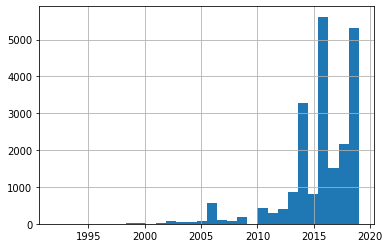

In [23]:
# Print number of observations older than 2010
old_data = combined_normalized_csv[combined_normalized_csv['TIME_PERIOD']<2010] 
print(old_data.shape)

# Visualize distribution of age of observations
combined_normalized_csv.loc[(combined_normalized_csv['TIME_PERIOD']>1990) & (combined_normalized_csv['TIME_PERIOD']<2020), 'TIME_PERIOD'].hist(bins = 30)

# Number of observations older than 2010
old_data_grouped = old_data.groupby('INDICATOR_NAME').count()

# Retrieve total number of observations
combined_normalized_csv_grouped = combined_normalized_csv.groupby('INDICATOR_NAME').count()

# Compare the number of rows older 2010 and total number of rows per indicators
old_data_analysis = old_data_grouped[['COUNTRY_ISO_3']].merge(
    right = combined_normalized_csv_grouped[['COUNTRY_ISO_3']],
    on = 'INDICATOR_NAME'
)

# Add column indicating % of obs older
old_data_analysis['OBS_PERCENT_OLDER_2010'] = round((old_data_analysis["COUNTRY_ISO_3_x"] / old_data_analysis["COUNTRY_ISO_3_y"]) * 100, 1) 


old_data_analysis.to_csv(
    path_or_buf = cwd / 'data_out' / 'percentage_old_data_per_indicator.csv',
    sep = ";"
)

## Create aggregated scores

In [11]:
# Read combined dataframe
combined_normalized_csv = pd.read_csv(
    cwd / 'data_out' / 'combined_normalized.csv',
    sep = ";"
)

# # # # # # # 
# Index score
index_score = combined_normalized_csv.loc[:, ['INDICATOR_INDEX','COUNTRY_ISO_3', 'SCALED_OBS_VALUE']].groupby(by = ['INDICATOR_INDEX','COUNTRY_ISO_3']).mean()

# Rename column 
index_score = index_score.rename(columns={'SCALED_OBS_VALUE' : 'ATTR_INDEX_SCORE'})

# Temp: Save dataframe
index_score.to_csv(    
    path_or_buf = cwd / 'data_out' / 'index_scores.csv',
    sep = ";")

# Join back to add column to original dataframe
combined_normalized_csv = combined_normalized_csv.merge(
    right=index_score,
    on=['INDICATOR_INDEX','COUNTRY_ISO_3']
)

# # # # # # # 
# Issue score
issue_score = combined_normalized_csv.loc[:, ['INDICATOR_ISSUE','COUNTRY_ISO_3', 'SCALED_OBS_VALUE']].groupby(by = ['INDICATOR_ISSUE','COUNTRY_ISO_3']).mean()

# Rename column
issue_score = issue_score.rename(columns={'SCALED_OBS_VALUE' : 'ATTR_ISSUE_SCORE'})

# Temp: Save dataframe
issue_score.to_csv(    
    path_or_buf = cwd / 'data_out' / 'issue_scores.csv',
    sep = ";")

# Join back to add column to original dataframe
combined_normalized_csv = combined_normalized_csv.merge(
    right=issue_score,
    on=['INDICATOR_ISSUE','COUNTRY_ISO_3']
)

# # # # # # # # 
# Caregory score
category_score = combined_normalized_csv.loc[:, ['INDICATOR_CATEGORY','COUNTRY_ISO_3', 'SCALED_OBS_VALUE']].groupby(by = ['INDICATOR_CATEGORY','COUNTRY_ISO_3']).mean()

# Rename column
category_score = category_score.rename(columns={'SCALED_OBS_VALUE' : 'ATTR_CATEGORY_SCORE'})

# Temp: Save dataframe
category_score.to_csv(    
    path_or_buf = cwd / 'data_out' / 'category_scores.csv',
    sep = ";")

# Join back to add column to original dataframe
combined_normalized_csv = combined_normalized_csv.merge(
    right=category_score,
    on=['INDICATOR_CATEGORY','COUNTRY_ISO_3']
)

# Save combined dataframe 
combined_normalized_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'combined_normalized.csv',
    sep = ";"
)

### Temp to export the results 

In [12]:
# Read combined dataframe
index_score_csv = pd.read_csv(
    cwd / 'data_out' / 'index_scores.csv',
    sep = ";"
)

index_score_csv = index_score_csv.merge(
    right=country_crba_list,
    how='left',
    on='COUNTRY_ISO_3'
)

index_score_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'index_scores.csv',
    sep = ";"
)


# DEVELOPMENT AND TRASH AREA

### UNCTAD sources

In [80]:
s_121 = pd.read_excel(    
    data_in
    / "data_raw_manually_extracted"
    / "S-121_CC.xlsx")

s_121['RAW_OBS_VALUE'] = s_121['Title of Legislation/Draft Legislation'].apply(lambda x: '2' if re.search('Draft', x) else '3')

# re.search("Draft", s_121.iloc[242, 1])

s_121[s_121['RAW_OBS_VALUE'] == '2']


# # # # # # 

s_122 = pd.read_excel(    
    data_in
    / "data_raw_manually_extracted"
    / "S-122_DP.xlsx")




s_122['RAW_OBS_VALUE'] = s_122['Title of Legislation/Draft Legislation'].apply(lambda x: '2' if re.search('Draft', x) else '3')

# re.search("Draft", s_121.iloc[242, 1])

s_122[s_122['RAW_OBS_VALUE'] == '2']

# s_122

,Country,Title of Legislation/Draft Legislation,Links to Laws,RAW_OBS_VALUE
72,Iraq,Draft Data Protection and Privacy Law,NaN,2
111,Pakistan,Electronic Data Protection Act 2005 - Draft (i...,http://media.mofo.com/docs/mofoprivacy/PAKISTA...,2
159,Zimbabwe,Draft Data Protection Bill 2016,http://www.techzim.co.zw/wp-content/uploads/20...,2


In [54]:
### IDMC
S_180_S181_s_189 = pd.read_excel(
    data_in
    / "data_raw_manually_extracted"
    / "S-180, S-181, S-189 idmc_displacement_all_dataset.xlsx",
)

# Define list to extract the relevant columns and save them as raw data csv
eit_list = [
    ["S-11_staged_raw.csv", [
        'Score.2',
        'Unnamed: 29'
        ]
    ],
    ["S-124_staged_raw.csv", [
        'Score.1',
        'Unnamed: 20'
        ]
    ],
    ["S-134_staged_raw.csv", [
        'Score.3',
        'Unnamed: 38'
        ]
    ], # To do: Currently waiting to hear back from Alex concerning soure S-120
    ["S-11_staged_raw.csv", [
        'Score.2',
        'Unnamed: 29'
        ]
    ]
]

# Loop through list
for element in eit_list:
    # Extract right columns
    dataframe = S_11_S120_s_124_s_134[element[1]]

    # Rename clumns
    dataframe = dataframe.rename(
        columns = {
            element[1][0]: 'RAW_OBS_VALUE',
            element[1][1]: 'COUNTRY_NAME'
            }
        )
    
    # Add year column
    dataframe['TIME_PERIOD'] = 2019

    # Save data
    dataframe.to_csv(data_sources_staged_raw / element[0], sep=";")

'\n# S-11: Legal framework\ns_11_raw = S_11_S120_s_124_s_134[[\'Score.2\', \'Unnamed: 29\']]\n\n# Rename columns\ns_11_raw = s_11_raw.rename(\n    columns = {\n        \'Score.2\': \'RAW_OBS_VALUE\',\n        \'Unnamed: 29\': \'COUNTRY_NAME\'\n    }\n)\n\n# Add year column\ns_11_raw[\'TIME_PERIOD\'] = 2019\n\n# Save\ns_11_raw.to_csv(data_sources_staged_raw / "S-11_staged_raw.csv", sep=";")\n'

## Extract selenium sources --> This code is stable as of 06.11.20, TO DO is to put this into a loop (which must be done in container, so I can only do it once James has looked at the issue with Chrome driver)

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Specify location of chromedriver
cwd = os.getcwd()
driver_location = cwd + '\\chromedriver.exe'

# Add option to make it headless (so that it doesn't open an actual chrome window)
options = Options()
options.headless = True
driver = webdriver.Chrome(driver_location, chrome_options=options)

# Get HTTP response
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312256:NO")
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO::P11300_INSTRUMENT_ID:312283")
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312328:NO")
response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312240:NO")

# Get response
# response = driver.get(html_url)

# Retrieve the actual html
html = driver.page_source

# Soupify
soup = bs.BeautifulSoup(html)

# Extract the target table as attribute
target_table = str(
    soup.find_all("table", {"cellspacing": "0", "class": "horizontalLine"})
)

# Create dataframe with the data
raw_data = pd.read_html(io=target_table, header=0)[
    0
]  # return is a list of DFs, specify [0] to get actual DF

# Cleansing
dataframe = cleanse.Cleanser().rename_and_discard_columns(
    raw_data=raw_data,
    mapping_dictionary=mapping_dict,
    final_sdmx_col_list=sdmx_df_columns_all
)

dataframe = cleanse.Cleanser().decompose_country_footnote_ilo_normlex(
    dataframe = dataframe,
    country_name_list = country_full_list.COUNTRY_NAME
)

dataframe = cleanse.Cleanser().add_and_discard_countries(
    grouped_data=dataframe,
    crba_country_list=country_crba_list,
    country_list_full = country_full_list
)

dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
    dataframe = dataframe,
    treaty_source_body='ILO NORMLEX'
)

# Normalizing section
dataframe_normalized = scaler.normalizer(
    cleansed_data = dataframe_cleansed,
    sql_subset_query_string=None
)

dataframe_normalized

C:\Users\Michael\anaconda3\envs\unicef-test\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: use options instead of chrome_options



 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...


,COUNTRY_NAME,ATTR_TREATY_STATUS,ATTR_FOOTNOTE_OF_SOURCE,COUNTRY_ISO_2,COUNTRY_ISO_3,_merge,RAW_OBS_VALUE,ATTR_ENCODING_LABELS,SCALED_OBS_VALUE,OBS_STATUS
0,Afghanistan,In Force,,AF,AFG,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
1,Albania,In Force,Excluding Article 11 by virtue of the ratifica...,AL,ALB,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
2,Algeria,In Force,,DZ,DZA,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
3,Argentina,In Force,,AR,ARG,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
4,Armenia,In Force,Excluding Article 11 by virtue of the ratifica...,AM,ARM,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
...,...,...,...,...,...,...,...,...,...,...
192,NaN,NaN,NaN,NaN,USA,right_only,1,"2=Yes, 1=No; as answer to the following questi...",0.0,nan
193,NaN,NaN,NaN,NaN,UZB,right_only,1,"2=Yes, 1=No; as answer to the following questi...",0.0,nan
194,NaN,NaN,NaN,NaN,VUT,right_only,1,"2=Yes, 1=No; as answer to the following questi...",0.0,nan
195,NaN,NaN,NaN,NaN,VNM,right_only,1,"2=Yes, 1=No; as answer to the following questi...",0.0,nan


In [ ]:
re.sub(dataframe["ATTR_FOOTNOTE_OF_SOURCE"][5]
       
# Speifically for ILO NORMLEX - extract country name if additonal info is given
#dataframe["ATTR_FOOTNOTE_OF_SOURCE"] = dataframe["COUNTRY_NAME"]
#dataframe["COUNTRY_NAME"] = dataframe["COUNTRY_NAME"].apply(extract_country_name)
#dataframe["ATTR_FOOTNOTE_OF_SOURCE"] = dataframe.apply(lambda x: re.sub(x['COUNTRY_NAME'], "", x["ATTR_FOOTNOTE_OF_SOURCE"]), 1)


In [ ]:
import requests
import bs4 as bs
import pandas as pd
import selenium
import os
from pathlib import Path
from selenium import webdriver

# cwd = Path('.')
cwd = os.getcwd()

# Current working directory
driver_location = cwd + '\\geckodriver.exe'

print(driver_location)

# Open the targete html. Must be done with selenium, because it doesnt work with normal URL request
#driver = webdriver.Firefox(executable_path="D:/Documents/2020/28_UNICEF/10_working_repo/data-etl/geckodriver.exe")
driver = webdriver.Firefox(executable_path=driver_location)

# Get HTTP response
response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312256:NO")


## GHG

problem: 

* Cannot use pd_json_normalize --> It won't unnest it becaust he years and actual values are given in [] rather than {}
* Stopped here: Must replace the character (but for that it is necessary to convert json to string and back)
* Next challnge: Get all data (and not only page 1) --> Main problem is that the API is not working, i.e. can't specify paramters

Stopped here 10.11.20 --> Need to get rid of "[]" signgs for 

In [57]:
dataframe_json = requests.get("https://www.climatewatchdata.org/api/v1/data/historical_emissions").text

dataframe_json_cleansed = dataframe_json.replace('[', '{').replace(']','}')
json_file = json.dumps(dataframe_json_cleansed)
# some_var = json.loads(dataframe_json_cleansed)
# type(some_var)
# pd.json_normalize(json_file)

In [39]:
temp = pd.json_normalize(requests.get("https://api.worldbank.org/v2/country/all/indicator/EL.EST?format=json&per_page=10000").json()[1])

type(temp)

{'indicator': {'id': 'RL.EST', 'value': 'Rule of Law: Estimate'}, 'country': {'id': 'AF', 'value': 'Afghanistan'}, 'countryiso3code': 'AFG', 'date': '2017', 'value': -1.569692, 'unit': '', 'obs_status': '', 'decimal': 0}


In [ ]:
for index_pos in len(range(dataframe_json['data'])):
    for         
    dataframe_json['data'][index_pos]['emissions']

In [56]:
def Convert(lst):
    res_dct = {lst[i]: lst[i + 1] for i in range(0, len(lst), 2)}
    return res_dct

print(Convert(dataframe_json['data'][3]['emissions']))

dataframe_json['data'][3]['emissions']

TypeError: unhashable type: 'dict'

In [ ]:
# # # # # # TEMP DELETE THIS
# temp = extract.JSONExtractor.extract(url = "https://api.worldbank.org/v2/country/all/indicator/VA.EST?format=json&per_page=10000")

temp = pd.json_normalize(requests.get("https://api.worldbank.org/v2/country/all/indicator/EL.EST?format=json&per_page=10000").json()[1])


# https://api.worldbank.org/v2/country/all/indicator/UIS.XPUBP.0?format=json&per_page=10000


temp

In [42]:
#dataframe = extract.CSVExtractor.extract(url = "https://www.climatewatchdata.org/api/v1/data/historical_emissions")

dataframe_json = requests.get("https://www.climatewatchdata.org/api/v1/data/historical_emissions").json()

cleaned_json = dataframe_json['data']# .replace('[', '{').replace
print(type(cleaned_json))
"""
# with open(dataframe_json, 'r') as file:
    content = file.read()
    clean = content.replace(']', '}')  # cleanup here
    json_data = json.loads(clean)
"""

# dataframe_2 = pd.json_normalize(dataframe_json['data'], max_level=5)

# dataframe_3 = pd.json_normalize(dataframe_json['data)


#dataframe_3

df = pd.json_normalize(cleaned_json)
df_2 = pd.json_normalize(df.loc[5, 'emissions'])

df_2

<class 'list'>


,year,value
0,1990,NaN
1,1991,NaN
2,1992,NaN
3,1993,NaN
4,1994,NaN
5,1995,NaN
6,1996,NaN
7,1997,NaN
8,1998,NaN
9,1999,NaN
